In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [107]:
# 역과 구 매칭
stn_gu = pd.read_csv('data/subway.csv', encoding='utf-8')

# 역별 승하차객 in/out
inout_pop = pd.read_csv('data/seoul_boarding_pop_by_subway.csv', encoding='utf-8')
inout_pop = inout_pop.drop('datetime', axis=1)

# 승차와 하차 비중
inout_rate = 0.5

# 구별 유동인구
floating_pop = pd.read_csv('data/skt_floating_pop.csv', encoding='utf-8')
floating_pop_mean = floating_pop.groupby(['hour','age','sex','si','gu'], as_index=False).mean()
floating_pop_mean = floating_pop_mean.drop(['datetime', 'si'], axis=1)

In [108]:
#이상치 제거
drop_index = list()

for stn in range(len(inout_pop)):
    total_pop_test = sum(inout_pop.iloc[stn, 2:50])
    if total_pop_test < 10000:
        drop_index += [stn]
print(drop_index)

inout_pop = inout_pop.drop(drop_index, axis=0)

[90, 191, 196, 317, 323, 351]


In [109]:
for stn_id in tqdm(range(len(inout_pop))):
    for time in ['morning', 'day', 'evening', 'night']:
        
        line_name, stn_name  = inout_pop.iloc[stn_id, 0:2]
        gu_match = (stn_gu['station'] == stn_name) & (stn_gu['line'] == line_name)
        gu = stn_gu[gu_match].gu.iloc[0] # 현재 gu는 1x1 dataframe. 따라서 그냥 값 읽기 과정
        
        if time == 'morning': hours = range(4, 10)
        elif time == 'day': hours = range(10, 16)
        elif time == 'evening': hours = range(16, 20)
        else: hours = range(20, 28) # night
        
        number_est = np.zeros((2,5)) # 각 성별, 연령대 인원수 추정값
        rate_est = np.zeros((2,5)) # 각 성별, 연령대 비율 추정값
        total_inout_pop = 0 # 총 승하차인원
        
        for sex in range(2):
            for age in range(5):
                
                for h in hours:
                    
                    # 해당 역의 h시-(h+1)시 승하차인원 계산
                    inout_pop_h = (inout_pop.iloc[stn_id, 2*(h-3)+0]
                                    + inout_rate * inout_pop.iloc[stn_id, 2*(h-3)+1])
                    
                    
                    # 해당 구 h시-(h+1)시 유동인구에서 해당 연령대 및 성별 비율 계산
                    cond_gu = (floating_pop_mean['gu'] == gu)
                    
                    if sex == 0:
                        cond_sex = (floating_pop_mean['sex'] == '남성')
                    else:
                        cond_sex = (floating_pop_mean['sex'] == '여성')
                    
                    if age != 4:
                        cond_age = (floating_pop_mean['age'] == 10*(age+2))
                    else:
                        cond_age = ((floating_pop_mean['age'] == 60) | (floating_pop_mean['age'] == 70))
                    
                    cond_h = (floating_pop_mean['hour'] == h % 24)
                    
                    numer = floating_pop_mean[cond_gu & cond_sex & cond_age & cond_h]['floating_pop'].sum()
                    # 분자는 해당 구 h시-(h+1)시 유동인구에서 해당 연령대 및 성별 인원
                    
                    denom = floating_pop_mean[cond_gu & cond_h]['floating_pop'].sum()
                    # 분모는 해당 구 h시-(h+1)시 전체 유동인구
                    
                    floating_pop_rate_h = numer / denom
                    
                    
                    # 각 성별, 연령대 인원수 추정값은 승하차인원*유동인구 비율을 시간에 따라 더함
                    number_est[sex][age] += inout_pop_h * floating_pop_rate_h
                    
                    # 총 승하차인원은 그냥 다 더함
                    total_inout_pop += inout_pop_h * floating_pop_rate_h
        
        if total_inout_pop == 0:
            rate_est = [[0.1, 0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1, 0.1]]
        else:
            rate_est = ([[number / total_inout_pop for number in number_est[0]],
                         [number / total_inout_pop for number in number_est[1]]]) # 각 성별, 연령대 비율 추정값
                
        globals()['stn%03d_%s' % (stn_id, time)] = rate_est + [total_inout_pop] # 변수명 ex. stn164_evening

100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [07:34<00:00,  1.23s/it]


In [110]:
# 클러스터링 위해 하나의 배열로 모으기
# row_number = 4*stn_id + time
# column_number = 5*sex + age
# 20남/30남/40남/50남/6-70남/20여/30여/40여/50여/6-70여

objects = np.zeros((len(inout_pop)*4, 2*5+1))

mod = sys.modules[__name__]


for stn_id in range(len(inout_pop)):
    for time in ['morning', 'day', 'evening', 'night']:
        
        stn_id_time = getattr(mod, 'stn%03d_%s' % (stn_id, time))
        
        if time == 'morning': t = 0
        elif time == 'day': t = 1
        elif time == 'evening': t = 2
        else: t = 3 # night
            
        for sex in range(2):
            for age in range(5):
                objects[4*stn_id + t, 5*sex + age] = stn_id_time[sex][age]
                
        objects[4*stn_id + t, 10] = stn_id_time[2]
        

In [111]:
f = open('data/clustering_parameters.csv', 'w')

f.write('20남,30남,40남,50남,6-70남,20여,30여,40여,50여,6-70여,총인원\n')

for obj in range(len(objects)):
    for i in range(10):
        f.write(str(objects[obj, i]) + ',')
    f.write(str(objects[obj, 10]) + '\n')

f.close()

In [112]:
#Normalization of rates

norm_objects = np.zeros((len(objects), 11))

mu_rate = np.zeros((2,5))
sigma_rate = np.zeros((2,5))

for sex in range(2):
    for age in range(5):
        mu_rate[sex][age] = np.mean(objects[:,5*sex+age])
        sigma_rate[sex][age] = np.std(objects[:,5*sex+age])
    
for sex in range(2):
    for age in range(5):
        for id in range(len(objects)):
            norm_objects[id][5*sex+age] = (objects[id][5*sex+age] - mu_rate[sex][age]) / sigma_rate[sex][age]

C:\Users\rlaals3620\Anaconda3\envs\dmenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rlaals3620\Anaconda3\envs\dmenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


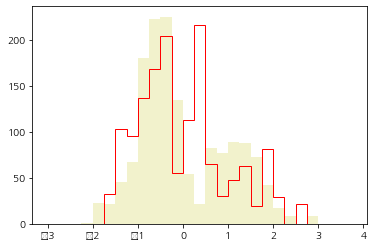

In [113]:
plt.hist(norm_objects[:,0], bins=np.arange(-3, 4, 0.25), alpha=0.2, color='y') # 20남
plt.hist(norm_objects[:,5], bins=np.arange(-3, 4, 0.25), alpha=1, histtype='step', color='r') # 20여
plt.show()

In [114]:
#Normalization of total_inout_pop.

mu_tot = np.mean(objects[:,10])
sigma_tot = np.std(objects[:,10])

for id in range(len(objects)):
    norm_objects[id][10] = (objects[id][10] - mu_tot) / sigma_tot

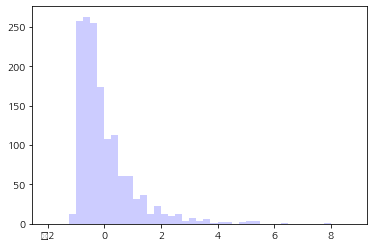

In [115]:
plt.hist(norm_objects[:,10], bins=np.arange(-2, 9, 0.25), alpha=0.2, color = 'b') # total_pop.
plt.show()

In [117]:
norm_objects_morning = np.zeros((len(inout_pop), 11))
norm_objects_day = np.zeros((len(inout_pop), 11))
norm_objects_evening = np.zeros((len(inout_pop), 11))
norm_objects_night = np.zeros((len(inout_pop), 11))

for stn in range(len(inout_pop)):
    norm_objects_morning[stn] = norm_objects[4*stn]
    norm_objects_day[stn] = norm_objects[4*stn+1]
    norm_objects_evening[stn] = norm_objects[4*stn+2]
    norm_objects_night[stn] = norm_objects[4*stn+3]

C:\Users\rlaals3620\Anaconda3\envs\dmenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rlaals3620\Anaconda3\envs\dmenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


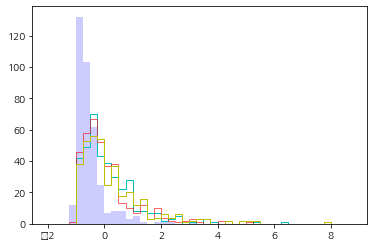

In [118]:
#시간대별 분포 차이
plt.hist(norm_objects_morning[:,10], bins=np.arange(-2, 9, 0.25), alpha=1, histtype='step', color='c') # morning
plt.hist(norm_objects_day[:,10], bins=np.arange(-2, 9, 0.25), alpha=0.6, histtype='step', color='r') # day
plt.hist(norm_objects_evening[:,10], bins=np.arange(-2, 9, 0.25), alpha=1, histtype='step', color='y') # evening
plt.hist(norm_objects_night[:,10], bins=np.arange(-2, 9, 0.25), alpha=0.2, color='b') # night
plt.show()

In [119]:
#Normalization of total_inout_pop. in logarithm
import math

log_total_pop = np.zeros(len(objects))
norm_log_total_pop = np.zeros(len(objects))

for id in range(len(objects)):
    log_total_pop[id] = math.log(1 + objects[id][10])

mu_log = np.mean(log_total_pop)
sigma_log = np.std(log_total_pop)

for id in range(len(objects)):
    norm_log_total_pop[id] = (log_total_pop[id] - mu_log) / sigma_log

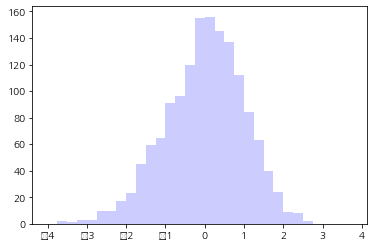

In [127]:
plt.hist(norm_log_total_pop, bins=np.arange(-4, 4, 0.25), alpha=0.2, color = 'b') # total_pop.
plt.show()

In [122]:
norm_log_total_pop_morning = np.zeros(len(inout_pop))
norm_log_total_pop_day = np.zeros(len(inout_pop))
norm_log_total_pop_evening = np.zeros(len(inout_pop))
norm_log_total_pop_night = np.zeros(len(inout_pop))

for stn in range(len(inout_pop)):
    norm_log_total_pop_morning[stn] = norm_log_total_pop[4*stn]
    norm_log_total_pop_day[stn] = norm_log_total_pop[4*stn+1]
    norm_log_total_pop_evening[stn] = norm_log_total_pop[4*stn+2]
    norm_log_total_pop_night[stn] = norm_log_total_pop[4*stn+3]

C:\Users\rlaals3620\Anaconda3\envs\dmenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rlaals3620\Anaconda3\envs\dmenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


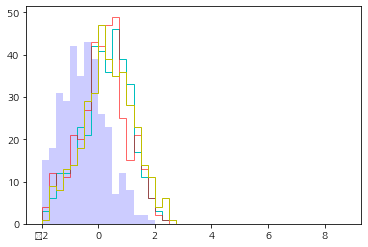

In [123]:
#시간대별 분포 차이
plt.hist(norm_log_total_pop_morning, bins=np.arange(-2, 9, 0.25), alpha=1, histtype='step', color='c') # morning
plt.hist(norm_log_total_pop_day, bins=np.arange(-2, 9, 0.25), alpha=0.6, histtype='step', color='r') # day
plt.hist(norm_log_total_pop_evening, bins=np.arange(-2, 9, 0.25), alpha=1, histtype='step', color='y') # evening
plt.hist(norm_log_total_pop_night, bins=np.arange(-2, 9, 0.25), alpha=0.2, color='b') # night
plt.show()

In [124]:
for id in range(len(objects)):
    norm_objects[id][10] = norm_log_total_pop[id]

In [125]:
f = open('data/norm_clustering_parameters.csv', 'w')

f.write('20남,30남,40남,50남,6-70남,20여,30여,40여,50여,6-70여,총인원\n')

for obj in range(len(norm_objects)):
    for i in range(10):
        f.write(str(norm_objects[obj, i]) + ',')
    f.write(str(norm_objects[obj, 10]) + '\n')

f.close()

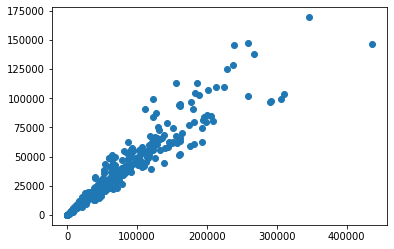

In [18]:
# 20-30대 승하차인원 vs 60-70대 승하차인원
# 시간대 분리

x = np.zeros((len(inout_pop)*4, 1))
y = np.zeros((len(inout_pop)*4, 1))

for i in range(len(inout_pop*4)):
    x[i] = objects[i][10] * (sum(objects[i][0:2]) + sum(objects[i][5:7]))
    y[i] = objects[i][10] * (objects[i][4] + objects[i][9])

plt.scatter(x, y)

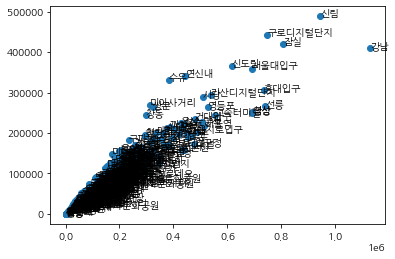

In [19]:
# 20-30대 승하차인원 vs 60-70대 승하차인원
# 시간대 합침

x = np.zeros((len(inout_pop)*4, 1))
y = np.zeros((len(inout_pop)*4, 1))

for i in range(len(inout_pop)):
    for j in range(4):
        x[i] += objects[4*i+j][10] * (sum(objects[4*i+j][0:2]) + sum(objects[4*i+j][5:7]))
        y[i] += objects[4*i+j][10] * (objects[4*i+j][4] + objects[4*i+j][9])

plt.rc('font', family='NanumGothic')        
plt.scatter(x, y)
for i in range(len(inout_pop)):
    plt.annotate('%s' % inout_pop.iloc[i, 1], (x[i], y[i]))